In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import wave
from IPython.display import Audio
import IPython
%matplotlib inline
!pip install noisereduce
import noisereduce as nr
from noisereduce.generate_noise import band_limited_noise
import os
import scipy as sp
from scipy.io.wavfile import write
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import torch
!pip install pydub
from pydub import AudioSegment
from pydub.silence import split_on_silence
import matplotlib.pyplot as plt
!pip install praat-parselmouth
import parselmouth
import scipy
import math
import IPython.display as ipd
import scipy.io.wavfile as wav
from scipy.io import wavfile
from scipy.signal import find_peaks
import scipy.io.wavfile as wav
from scipy.signal import freqz

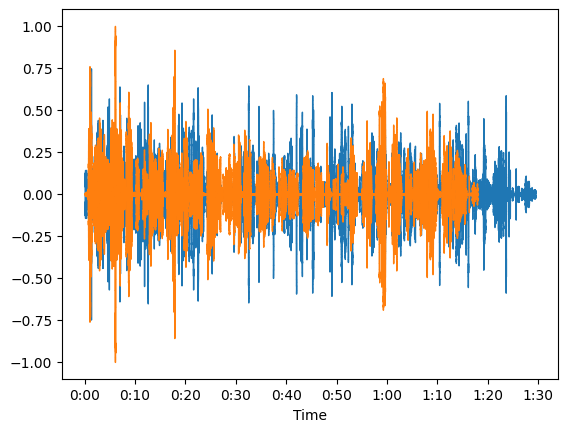

In [ ]:
path_src1 = "/content/drive/MyDrive/Dementia Dataset/Trimmed audio files_via code"
audio_filename1 = 'speaker1_output.wav'
audio_file_path1 = os.path.join(path_src1, audio_filename1)

path_src2 = "/content/drive/MyDrive/Dementia Dataset/Trimmed_Trained_audio_normal"
audio_filename2 = 'adrso002.wav'
audio_file_path2 = os.path.join(path_src2, audio_filename2)

if os.path.exists(audio_file_path1):
    waveform, sample_rate = librosa.load(audio_file_path1)
    librosa.display.waveshow(waveform, sr=sample_rate)
    IPython.display.Audio(data=waveform, rate=sample_rate)
else:
    print("Audio file not found:", audio_file_path1)

if os.path.exists(audio_file_path2):
    waveform2, sample_rate2 = librosa.load(audio_file_path2)
    librosa.display.waveshow(waveform2, sr=sample_rate2)
    IPython.display.Audio(data=waveform2, rate=sample_rate2)
else:
    print("Audio file not found:", audio_file_path2)


In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(waveform)
IPython.display.Audio(data=waveform,rate = sample_rate)

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(waveform2)
IPython.display.Audio(data=waveform2,rate = sample_rate2)

'We tried using other filters like moving average,derivative based,gaussian filter,noise gating,non-stationary noise filtering on our own,but we did not get the desired results,\nHence we used a built in function for the same'

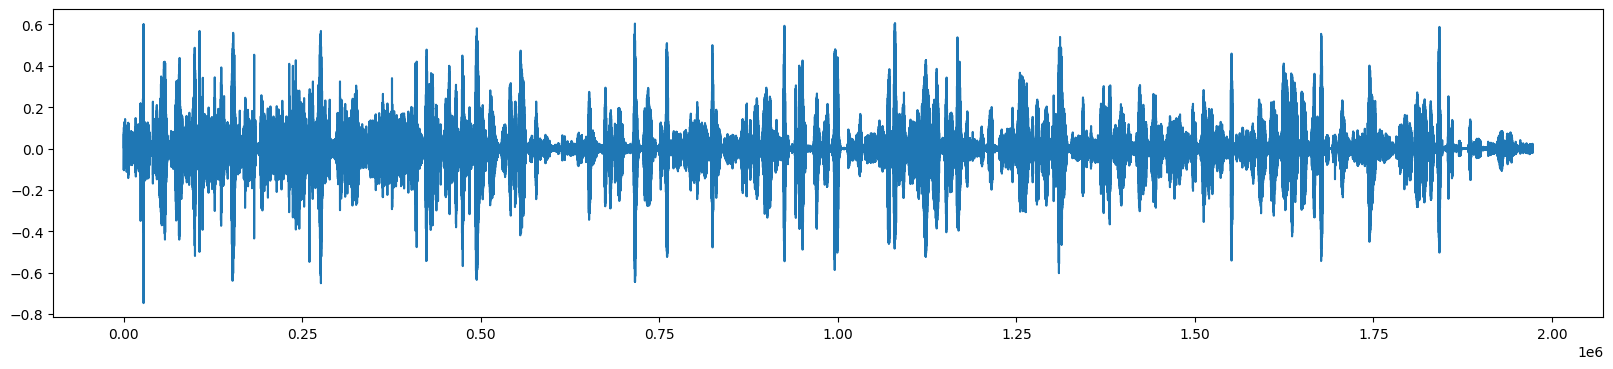

In [ ]:
reduced_noise = nr.reduce_noise(y=waveform, sr=sample_rate, n_std_thresh_stationary=1,stationary=True)  # removing only stationary voice
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(waveform)
IPython.display.Audio(data=reduced_noise,rate = sample_rate)
"""We tried using other filters like moving average,derivative based,gaussian filter,noise gating,non-stationary noise filtering on our own,but we did not get the desired results,
Hence we used a built in function for the same"""

In [ ]:
def moving_average_filter(signal, window_size):
    filtered_signal = np.zeros_like(signal)
    for i in range(len(signal)):
        if i >= window_size - 1:
            filtered_signal[i] = np.mean(signal[i-window_size+1:i+1])
    return filtered_signal

def compute_frequency_response():
    b = np.ones(window_size) / window_size
    w, h = freqz(b, worN=8000)
    plt.figure(figsize=(10, 6))
    plt.plot(0.5 * sampling_frequency * w / np.pi, np.abs(h), 'b')
    plt.title("Frequency Response of Moving Average Filter")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid()
    plt.show()
sampling_frequency = sample_rate2
window_size = 2
filtered_signal_normal = moving_average_filter(waveform2, window_size)
reduced_noise = moving_average_filter(waveform, window_size)
#using librosa to plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(filtered_signal_normal)
compute_frequency_response()
IPython.display.Audio(data=filtered_signal_normal,rate = sample_rate2)

Fundamental Frequency: 0.04469740314169026 Hz


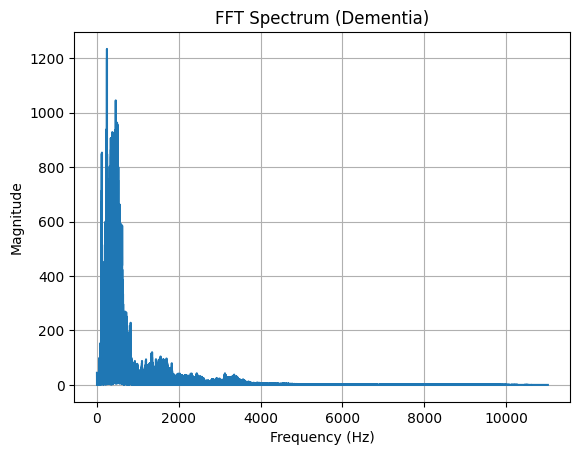

In [ ]:
def funda_freq(signal):
    windowed_data = reduced_noise * np.hamming(len(reduced_noise))
    fft_result = np.fft.fft(windowed_data)
    frequencies = np.fft.fftfreq(len(fft_result), 1 / sample_rate)
    magnitude_spectrum = np.abs(fft_result)
    peaks, _ = find_peaks(magnitude_spectrum)
    peak_frequency = frequencies[peaks][0]
    fundamental_frequency = abs(peak_frequency)
    print("Fundamental Frequency:", fundamental_frequency, "Hz")
    return peaks,fundamental_frequency,frequencies,magnitude_spectrum


peaks1,f01,frequencies1,magnitude_spectrum1=funda_freq(reduced_noise)
# Plot FFT spectrum
plt.plot(frequencies1[:len(frequencies1)//2], magnitude_spectrum1[:len(frequencies1)//2])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT Spectrum (Dementia)")
plt.grid(True)
plt.show()

Fundamental Frequency: 0.04469740314169026 Hz


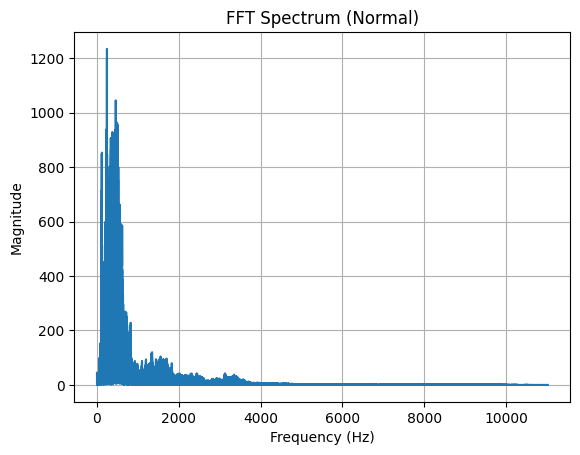

In [ ]:
peaks2,f02,frequencies2,magnitude_spectrum2=funda_freq(filtered_signal_normal)
# Plot FFT spectrum
plt.plot(frequencies2[:len(frequencies2)//2], magnitude_spectrum2[:len(frequencies2)//2])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT Spectrum (Normal)")
plt.grid(True)
plt.show()

Pause lengths:
Pause 1: 26.946 seconds
Pause 2: 56.21 seconds
Pause 3: 0.668 seconds
Pause 4: 0.94 seconds


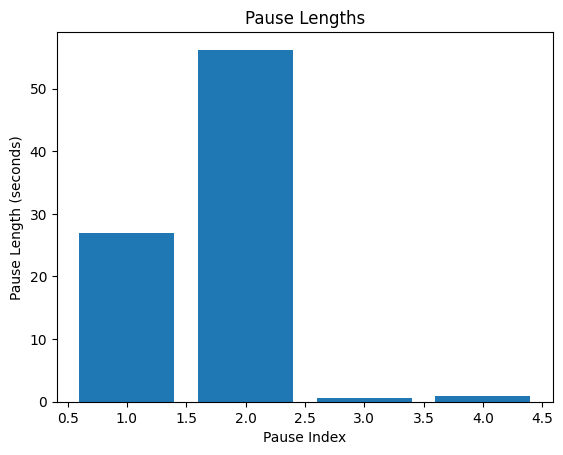

84.76400000000001


In [ ]:
#Pause length Dementia
def pause(filepath):
  audio = AudioSegment.from_wav(filepath)
  silent_segments = split_on_silence(audio, min_silence_len=1000, silence_thresh=-40)
  print("Pause lengths:")
  for i, segment in enumerate(silent_segments):
    pause_length_ms = len(segment)
    pause_length_sec = pause_length_ms / 1000
    print(f"Pause {i+1}: {pause_length_sec} seconds")
  for i, segment in enumerate(silent_segments):
    segment.export(f"pause_{i+1}.wav", format="wav")
  psl = [len(segment) / 1000 for segment in silent_segments]
  return psl


pause_lengths_sec1=pause(audio_file_path1)
# Plot

plt.bar(range(1, len(pause_lengths_sec1) + 1), pause_lengths_sec1)
plt.xlabel('Pause Index')
plt.ylabel('Pause Length (seconds)')
plt.title('Pause Lengths')
plt.show()
pause_length_total=sum(pause_lengths_sec1)
print(pause_length_total)

Pause lengths:
Pause 1: 23.286 seconds
Pause 2: 8.82 seconds
Pause 3: 15.909 seconds
Pause 4: 3.29 seconds
Pause 5: 14.79 seconds
Pause 6: 4.878 seconds
Pause 7: 1.162 seconds


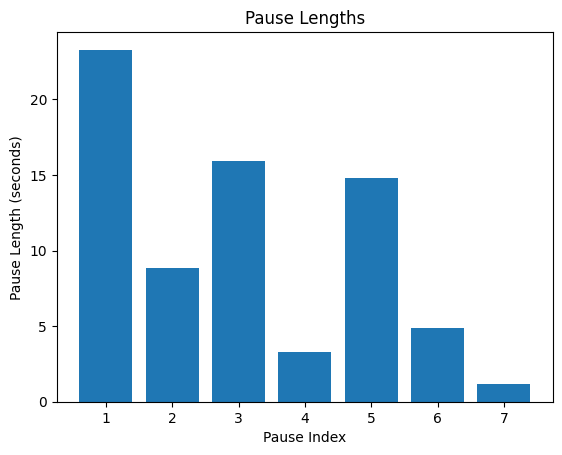

72.135


In [ ]:
# Plot
pause_lengths_sec2 = pause(audio_file_path2)
plt.bar(range(1, len(pause_lengths_sec2) + 1), pause_lengths_sec2)
plt.xlabel('Pause Index')
plt.ylabel('Pause Length (seconds)')
plt.title('Pause Lengths')
plt.show()
pause_length_total=sum(pause_lengths_sec2)
print(pause_length_total)

<ipython-input-54-fdd76bcf22e5>:1: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(reduced_noise,n_fft=500), ref=np.max)


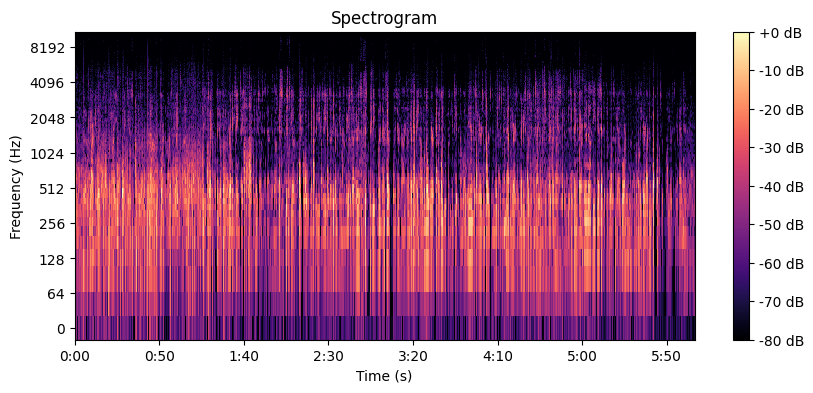

In [ ]:
D = librosa.amplitude_to_db(librosa.stft(reduced_noise,n_fft=500), ref=np.max)

# Plot spectrogram Dementia
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

<ipython-input-55-2f889896ee19>:1: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(filtered_signal_normal,n_fft=500), ref=np.max)


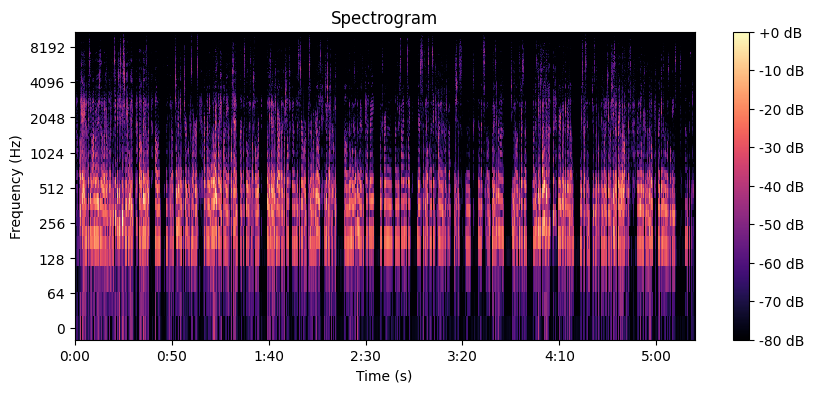

In [ ]:
D = librosa.amplitude_to_db(librosa.stft(filtered_signal_normal,n_fft=500), ref=np.max)

# Plot spectrogram Normal
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sample_rate2, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

DEMENTIA
Duration: 44.74532879818594
Mean Pitch: 128.17187635878884
Pitch Range: 599.5731044832519
Mean Intensity: 62.71106836514546
Intensity Range: 64.98477648221203
Mean F1: 457.3711405037184
Melodic Contour: [0. 0. 0. ... 0. 0. 0.]


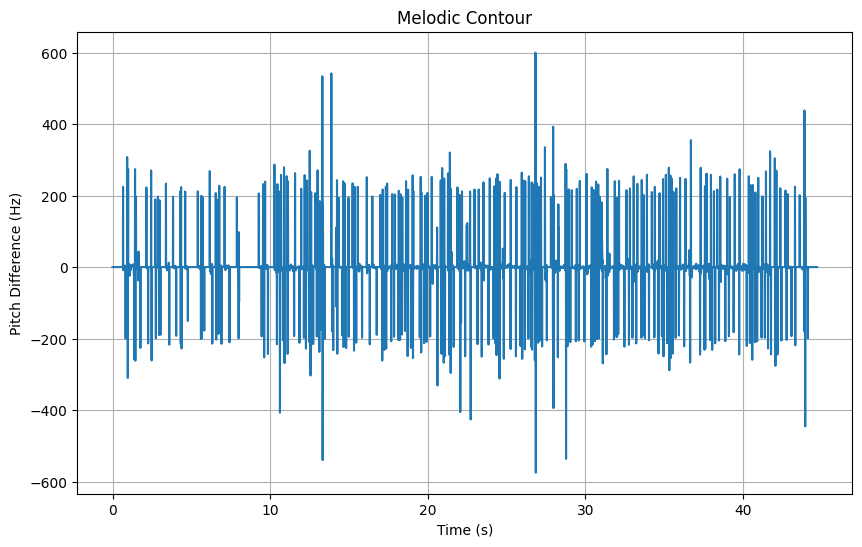

In [ ]:
def extract_acoustic_features1(audio_file):
    snd = parselmouth.Sound(audio_file)
    duration = snd.get_total_duration()
    pitch = snd.to_pitch()
    mean_pitch = np.nanmean(pitch.selected_array['frequency'])
    pitch_range = np.nanmax(pitch.selected_array['frequency']) - np.nanmin(pitch.selected_array['frequency'])
    intensity = snd.to_intensity()
    mean_intensity = np.nanmean(intensity.values)
    intensity_range = np.nanmax(intensity.values) - np.nanmin(intensity.values)
    formants = snd.to_formant_burg()
    mean_f1 = formants.get_value_at_time(1, snd.duration / 2, parselmouth.FormantUnit.HERTZ)
    melodic_contour = compute_melodic_contour(pitch)

    return duration, mean_pitch, pitch_range, mean_intensity, intensity_range, mean_f1, melodic_contour

def compute_melodic_contour(pitch):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[np.isnan(pitch_values)] = 0
    melodic_contour = np.diff(pitch_values)
    return melodic_contour


duration, mean_pitch, pitch_range, mean_intensity, intensity_range, mean_f1, melodic_contour = extract_acoustic_features1(reduced_noise)
#Print Dementia
print("DEMENTIA")
print("Duration:", duration)
print("Mean Pitch:", mean_pitch)
print("Pitch Range:", pitch_range)
print("Mean Intensity:", mean_intensity)
print("Intensity Range:", intensity_range)
print("Mean F1:", mean_f1)
print("Melodic Contour:", melodic_contour)
time_step = 1 / 100
time_points = np.arange(0, len(melodic_contour)) * time_step
plt.figure(figsize=(10, 6))
plt.plot(time_points, melodic_contour)
plt.xlabel('Time (s)')
plt.ylabel('Pitch Difference (Hz)')
plt.title('Melodic Contour')
plt.grid(True)
plt.show()




NORMAL
Duration: 39.02945578231292
Mean Pitch: 209.87192618944135
Pitch Range: 594.954727647313
Mean Intensity: 58.267254873040486
Intensity Range: 79.92350552032875
Mean F1: 791.2968926775753
Melodic Contour: [0. 0. 0. ... 0. 0. 0.]


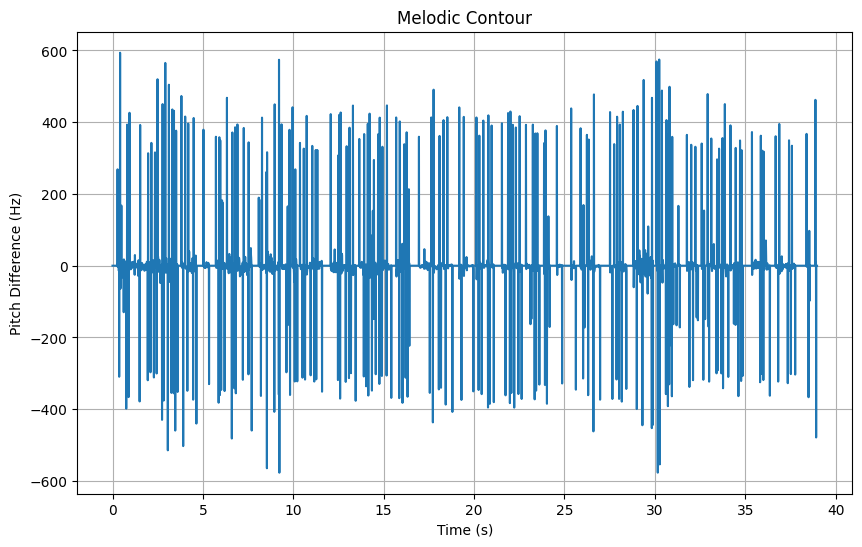

In [ ]:
duration, mean_pitch, pitch_range, mean_intensity, intensity_range, mean_f1, melodic_contour = extract_acoustic_features1(filtered_signal_normal)
#Print NORMAL
print("NORMAL")
print("Duration:", duration)
print("Mean Pitch:", mean_pitch)
print("Pitch Range:", pitch_range)
print("Mean Intensity:", mean_intensity)
print("Intensity Range:", intensity_range)
print("Mean F1:", mean_f1)
print("Melodic Contour:", melodic_contour)
time_step = 1 / 100
time_points = np.arange(0, len(melodic_contour)) * time_step
plt.figure(figsize=(10, 6))
plt.plot(time_points, melodic_contour)
plt.xlabel('Time (s)')
plt.ylabel('Pitch Difference (Hz)')
plt.title('Melodic Contour')
plt.grid(True)
plt.show()

In [ ]:
def calculate_jitter(period_lengths):
   diff_periods = np.diff(period_lengths)
   jitter = np.mean(np.abs(diff_periods)) / np.mean(period_lengths) * 100  # Express as percentage
   return jitter

# Function to calculate shimmer
def calculate_shimmer(amplitudes):
    N = len(amplitudes)
    numerator = np.sum(np.abs(amplitudes[:-1] - amplitudes[1:])) / (N - 1)
    denominator = np.mean(amplitudes)
    shimmer = numerator / denominator
    shimmer_db = 20 * np.log10(shimmer)
    return shimmer_db

period_lengths = np.arange(0, len(reduced_noise), f01)
amplitudes = np.abs(reduced_noise[period_lengths.astype(int)])

jitter = calculate_jitter(period_lengths)
shimmer = calculate_shimmer(amplitudes)

print("Jitter:", jitter)
print("Shimmer:", shimmer)


Jitter: 4.530289914770525e-06
Shimmer: -44.62570070574955


In [ ]:
period_lengths = np.arange(0, len(filtered_signal_normal), f02)
amplitudes = np.abs(filtered_signal_normal[period_lengths.astype(int)])


jitter = calculate_jitter(period_lengths)
shimmer = calculate_shimmer(amplitudes)

print("Jitter:", jitter)
print("Shimmer:", shimmer)

Jitter: 5.193752009819725e-06
Shimmer: -44.74412851654102


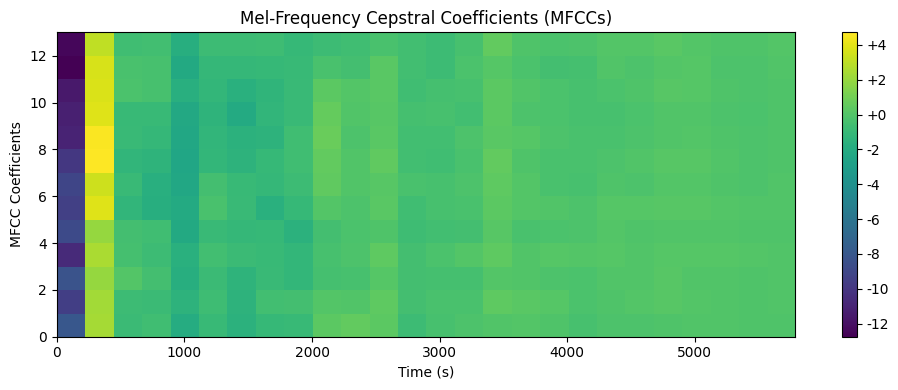

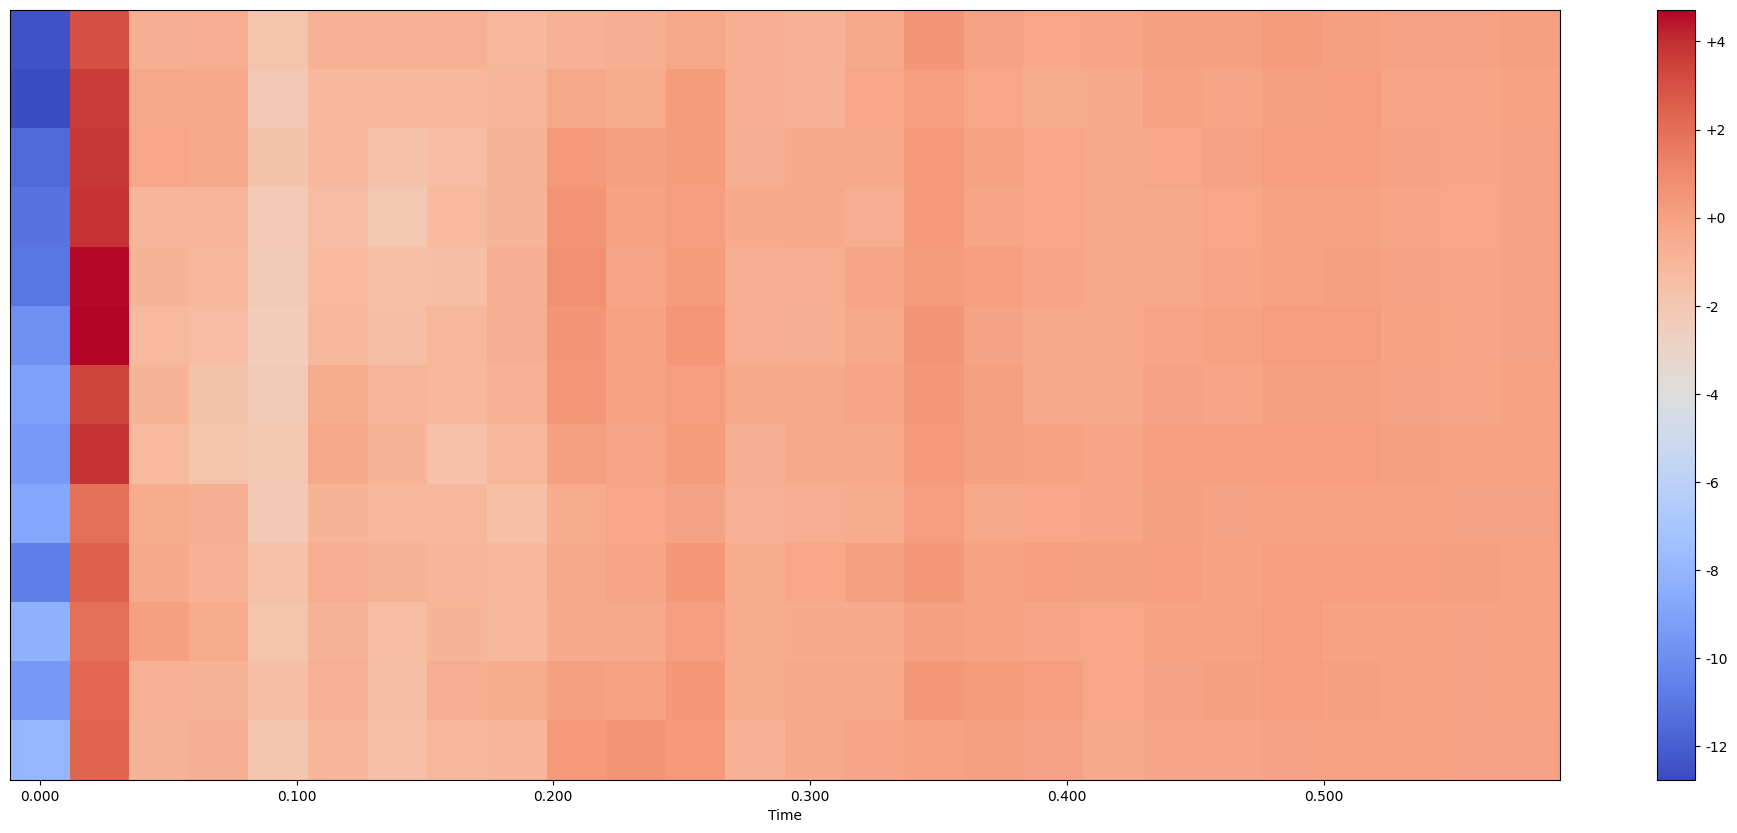

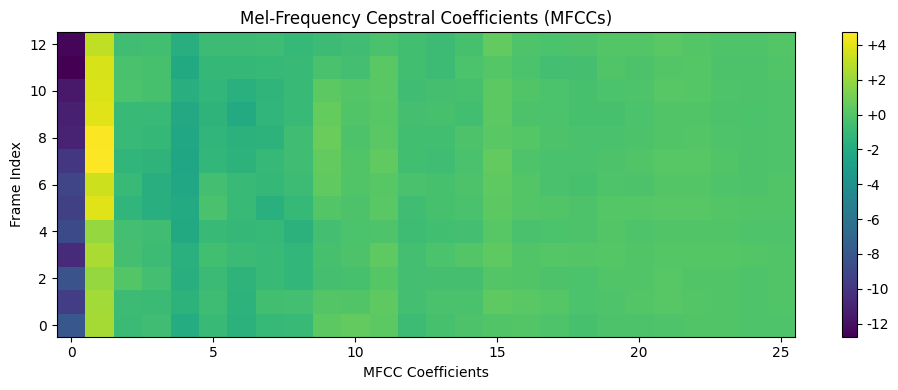

[[-7.98773423e+00  2.37149075e+00 -8.32332261e-01 -6.51113797e-01
  -1.94878209e+00 -1.00918655e+00 -1.52043247e+00 -1.05397473e+00
  -1.00347821e+00  3.45007739e-01  4.92639173e-01  3.13242552e-01
  -7.48519973e-01 -3.66102919e-01 -1.77907520e-01 -8.71753431e-03
   6.49995994e-02 -5.89001781e-02 -3.56877849e-01 -1.43310363e-01
  -1.88836460e-01 -8.15104469e-02 -6.96314497e-03  3.85983522e-03
  -1.25207400e-01 -9.80545371e-02]
 [-9.49881678e+00  2.32751319e+00 -7.60977099e-01 -8.74589669e-01
  -1.46425120e+00 -7.13773438e-01 -1.47732936e+00 -5.94730778e-01
  -5.31524832e-01  3.11815687e-02 -2.03672372e-02  3.70685183e-01
  -4.67579883e-01 -2.87806443e-01 -3.18803283e-01  3.89690373e-01
   2.68393621e-01  1.13890721e-01 -2.10340243e-01 -1.11093489e-01
   3.34177520e-02  2.07519163e-01  7.79537188e-02 -2.15146821e-02
  -6.08837534e-02 -2.75274444e-02]
 [-8.27936046e+00  1.95677328e+00  1.93681565e-02 -4.95607977e-01
  -1.79795403e+00 -8.13937706e-01 -1.39474640e+00 -9.08160482e-01
  -1.1

In [ ]:
#MFCC
def pre_emphasis(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])
def frame_signal(signal, frame_size, frame_stride, sample_rate):
    frame_length, frame_step = int(frame_size * sample_rate), int(frame_stride * sample_rate)
    signal_length = len(signal)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
    pad_signal_length = num_frames * frame_step + frame_length
    padded_signal = np.pad(signal, (0, pad_signal_length - signal_length), 'constant')
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = padded_signal[indices.astype(np.int32, copy=False)]
    return frames
def apply_window(frames, window_type='hamming'):
    if window_type == 'hamming':
        return frames * np.hamming(frames.shape[1])
    elif window_type == 'hanning':
        return frames * np.hanning(frames.shape[1])
    elif window_type == 'rectangular':
        return frames
def compute_spectrum(frames, n_fft):
    return np.abs(np.fft.rfft(frames, n_fft))
def mel_filterbank(num_filters, n_fft, sample_rate):
    mel_filters = np.zeros((num_filters, int(np.floor(n_fft / 2 + 1))))
    mel_points = np.linspace(0, (2595 * np.log10(1 + (sample_rate / 2) / 700)), num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin_points = np.floor((n_fft + 1) * hz_points / sample_rate)
    for i in range(1, num_filters + 1):
        mel_filters[i - 1, int(bin_points[i - 1]):int(bin_points[i])] = (bin_points[i] - bin_points[i - 1]) / (bin_points[i + 1] - bin_points[i - 1])
        mel_filters[i - 1, int(bin_points[i]):int(bin_points[i + 1])] = (bin_points[i + 1] - bin_points[i]) / (bin_points[i + 1] - bin_points[i - 1])
    return mel_filters

def mfcc(signal, sample_rate, frame_size=0.025, frame_stride=0.01, num_filters=26, n_ceps=13, n_fft=512):
    emphasized_signal = pre_emphasis(signal)
    frames = frame_signal(emphasized_signal, frame_size, frame_stride, sample_rate)
    windowed_frames = apply_window(frames)
    spectrum = compute_spectrum(windowed_frames, n_fft)
    mel_filters = mel_filterbank(num_filters, n_fft, sample_rate)
    mel_spectrum = np.dot(spectrum, mel_filters.T)
    mel_spectrum = np.where(mel_spectrum == 0, np.finfo(float).eps, mel_spectrum)
    mfcc_coeffs = np.dot(np.log(mel_spectrum), scipy.fftpack.dct(np.identity(num_filters), norm='ortho'))[:n_ceps]
    return mfcc_coeffs
mfcc_coeffs1 = mfcc(reduced_noise, sample_rate)
mfcc_coeffs2=mfcc(filtered_signal_normal,sample_rate2)
frame_size = 0.025
frame_stride = 0.01
num_frames1 = mfcc_coeffs1.shape[1]
frame_indices1 = np.arange(num_frames1)
time_values1 = (frame_indices1 * frame_stride + frame_size / 2) * sample_rate

num_frames2 = mfcc_coeffs2.shape[1]
frame_indices2 = np.arange(num_frames2)
time_values2 = (frame_indices2 * frame_stride + frame_size / 2) * sample_rate2

plt.figure(figsize=(10, 4))
plt.imshow(mfcc_coeffs1, cmap='viridis', origin='lower', aspect='auto', extent=[0, time_values1[-1], 0, mfcc_coeffs1.shape[0]])
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.title('Mel-Frequency Cepstral Coefficients (MFCCs)')
plt.colorbar(format="%+2.f")
plt.tight_layout()
plt.show()


plt.figure(figsize=(25, 10))
librosa.display.specshow(mfcc_coeffs1, x_axis="time",sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()

plt.figure(figsize=(10, 4))
plt.imshow(mfcc_coeffs1, cmap='viridis', origin='lower', aspect='auto')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Frame Index')
plt.title('Mel-Frequency Cepstral Coefficients (MFCCs)')
plt.colorbar(format="%+2.f")
plt.tight_layout()
plt.show()

print(mfcc_coeffs1)

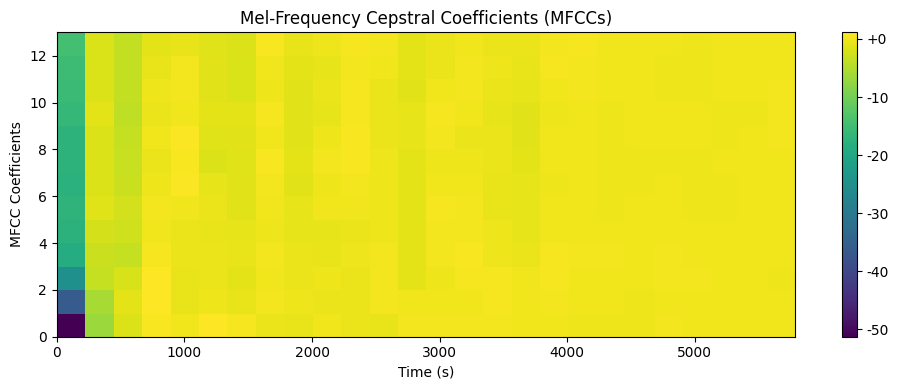

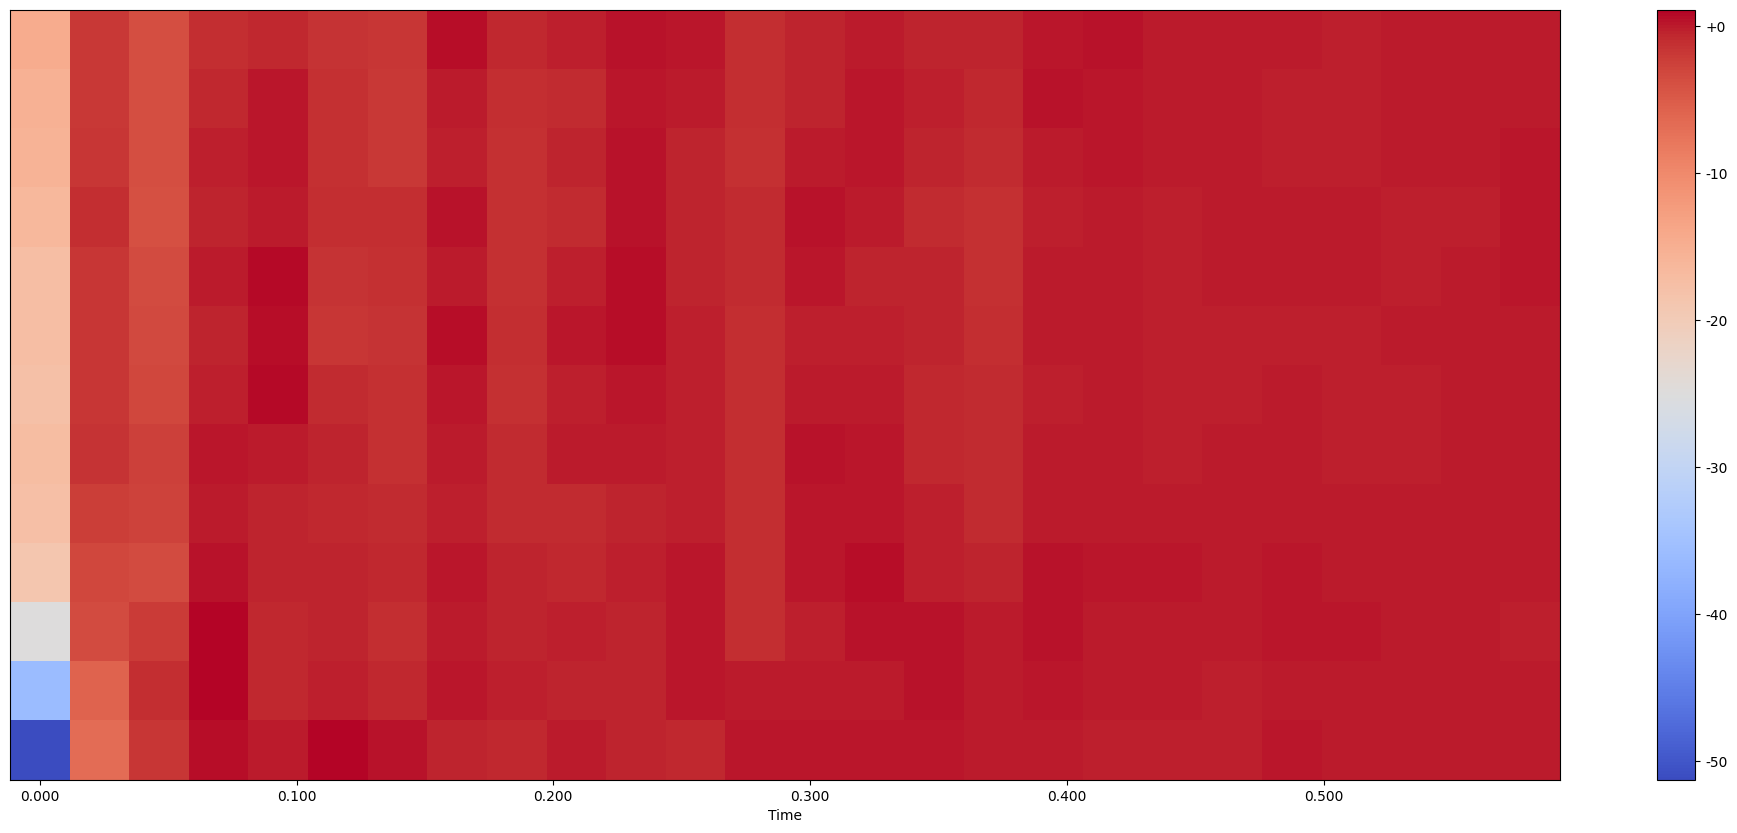

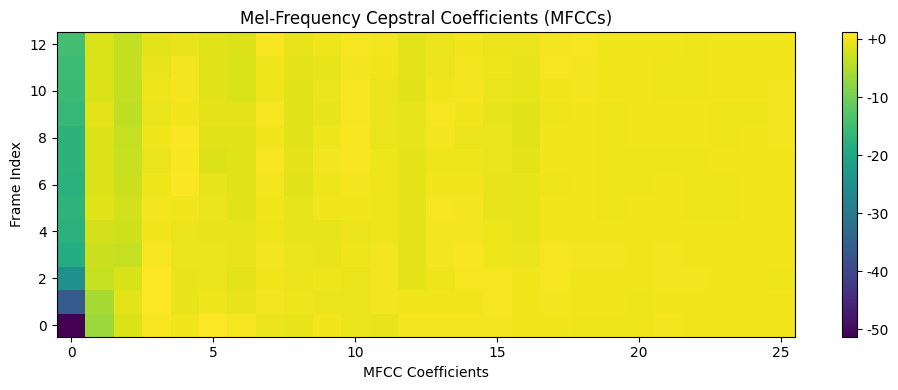

[[-5.12623795e+01 -6.71225082e+00 -1.56856316e+00  5.85656617e-01
  -9.06720037e-02  1.11280792e+00  4.35385297e-01 -3.98994454e-01
  -6.64533241e-01 -7.92977189e-02 -4.02649930e-01 -5.39041194e-01
   1.15351057e-01  2.16610308e-01  1.35507005e-01  2.39864855e-01
   2.91479595e-02  9.80948177e-02 -1.38499358e-01 -2.18678867e-01
  -1.44710263e-01  1.54837520e-01 -5.06343907e-03  7.91271250e-02
   2.91858191e-02  8.35517671e-02]
 [-3.60098807e+01 -5.64078179e+00 -1.10864042e+00  1.13044857e+00
  -5.95348966e-01 -1.75969354e-01 -6.01108569e-01  1.81671543e-01
  -1.93615339e-01 -4.37338540e-01 -4.63347904e-01  2.29079967e-01
  -2.52710889e-02 -7.97907047e-02  5.68148455e-03  3.58187777e-01
   1.96458481e-02  3.03055302e-01 -8.33380383e-03  2.77697868e-02
  -1.33205331e-01  3.11970129e-02  2.46267540e-02  5.73118589e-03
   2.78197758e-02  2.39522010e-02]
 [-2.48747888e+01 -3.44963297e+00 -2.12113076e+00  1.13216348e+00
  -5.99277043e-01 -3.89493147e-01 -1.06244639e+00 -7.34109651e-02
  -3.8

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_coeffs2, cmap='viridis', origin='lower', aspect='auto', extent=[0, time_values2[-1], 0, mfcc_coeffs2.shape[0]])
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.title('Mel-Frequency Cepstral Coefficients (MFCCs)')
plt.colorbar(format="%+2.f")
plt.tight_layout()
plt.show()


plt.figure(figsize=(25, 10))
librosa.display.specshow(mfcc_coeffs2, x_axis="time",sr=sample_rate2)
plt.colorbar(format="%+2.f")
plt.show()

plt.figure(figsize=(10, 4))
plt.imshow(mfcc_coeffs2, cmap='viridis', origin='lower', aspect='auto')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Frame Index')
plt.title('Mel-Frequency Cepstral Coefficients (MFCCs)')
plt.colorbar(format="%+2.f")
plt.tight_layout()
plt.show()

print(mfcc_coeffs2)